# <목차>
1. CNN 개념
2. MNIST 이미지 분류기 구현
3. CIFAR-10 이미지 분류기 구현
4. 대표적인 CNN 모델들
  - AlexNet
  - VGGNet
  - GoogLeNet(Inception v1)
  - ResNet
5. tf.train.Saver API 이용

# 1. CNN 개념
---
**C**onvolutional **N**eural **N**etwork  
이미지 분야를 다루기에 최적화된 인공신경망 구조
- Convolution Layer
  - 컨볼루션 연산을 통해 이미지의 특징 추출  
  - 어떤 커널을 사용하느냐에 따라 원본 이미지에서 다양한 특징을 추출 가능  
    ex) 모서리 추출(둥근가? 각져있나?), 선명도  
    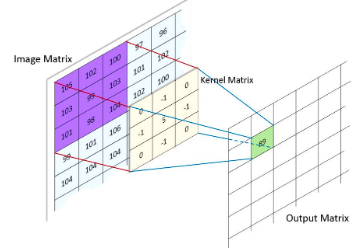  
      - 컨볼루션층 결과로 출력되는 차원  -> **[가로길이, 세로길이, 컨볼루션 필터 개수]**  
    세로 길이 계산 : H_out =  (H_in - F + 2P) / S + 1
    > F: 필터의 크기  
    > S: 스트라이드(컨볼루션 연산시 건너뛰는 정도)   
    > P: 인풋 이미지의 모서리에 P만큼 0을 채워주는 **제로패딩**  
- Pooling(Subsampling) Layer
  - 차원을 축소하는 연산 수행
  - 종류: 최대값, 평균값, 최소값 풀링
  - 장점: 연산량 감소, 특징 선별 효과  
  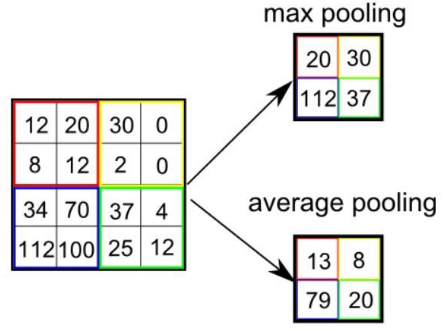

> **분류문제를 위한 CNN의 경우**   
>  1) 최종 추출된 활성화 맵들은 마지막에 Flattening으로 펼친 다음  
>  2) ANN 구조인 완전 연결층의 인풋으로 들어가서  
>  3) Softmax 분류 수행

#2. CNN 분류기 구현
---
**tf.nn.conv2d**(input, filter, strides, padding, dilations = [1,1,1,1], name=None)  
> - input: [batch, in_height, in_width, in_channels] 
> - filter: [filter_height, filter_width, in_channels, out_channels]
> - strides: [배치, 가로, 세로, 채널] 건너뛸 픽셀 수   
> - padding: "SAME" 또는 "VALID"  
    - SAME: input의 가로, 세로 차원과 같은 크기로 리턴되도록 작아진 차원부분에 0을 채운 **제로패딩** 적용  
    - VALID: 컨볼루션 연산 공식에 의해 계산된 차원이 리턴  
> - dilation: Dilated Convolution을 적용하고 싶을 경우, Dilation Factor를 길이 4의 list로 지정

**tf.nn.max(avg)_pool**(value, ksize, strides, name=None)
> - value:  [batch, in_height, in_width, in_channels]   
> - ksize:  [batch_filter, height_filter, width_filter, channel_filter]  
  (p.s. 일반적으로 배치, 채널에는 풀링을 적용하지 않아 1로 지정)  
> - strides:  [배치, 가로, 세로, 채널] 건너뛸 픽셀 수  
  (p.s. 일반적으로 배치, 채널에는 풀링을 적용하지 않아 1로 지정) 


In [ ]:
#!pip install tensorflow==1.2
import tensorflow as tf

#데이터 다운로드
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

In [5]:
#모델 정의
def build_CNN_classifier(x):
  #3차원 형태로 reshape
  x_image = tf.reshape(x, [-1, 28, 28, 1])

  #1번째 컨볼루션층
  W_conv1 = tf.Variable(tf.truncated_normal(shape=[5,5,1,32], stddev=5e-2))
  b_conv1 = tf.Variable(tf.constant(0.1, shape=[32]))
  h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1,1,1,1], padding='SAME') + b_conv1)

  #1번째 풀링층: 이미지의 크기를 1/2로 downsample
  h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

  #2번째 컨볼루션층
  W_conv2 = tf.Variable(tf.truncated_normal(shape=[5,5,32,64], stddev=5e-2))
  b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))
  h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W_conv2, strides=[1,1,1,1], padding='SAME') + b_conv2)

  #2번째 풀링층: 이미지의 크기를 1/2로 downsample
  h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

  #완전 연결층
  W_fc1 = tf.Variable(tf.truncated_normal(shape=[7*7*64, 1024], stddev=5e-2))
  b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
  #flatting
  h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
  h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

  #출력층
  W_output = tf.Variable(tf.truncated_normal(shape=[1024, 10], stddev=5e-2))
  b_output = tf.Variable(tf.constant(0.1, shape=[10]))
  logits = tf.matmul(h_fc1, W_output) + b_output
  y_pred = tf.nn.softmax(logits)

  return y_pred, logits

In [6]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10])

#CNN 분류기 정의
y_pred, logits = build_CNN_classifier(x)
#손실함수 정의
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=logits))
#옵티마이저 정의
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

#정확도 계산
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
#학습 진행
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for i in range(10000):
    batch = mnist.train.next_batch(50)
    if i % 100 == 0:
      train_accuracy = accuracy.eval(feed_dict={x:batch[0], y:batch[1]})
      print("반복: %d, training data 정확도: %f" %(i, train_accuracy))
    sess.run([train_step], feed_dict={x:batch[0], y:batch[1]}) #파라미터를 한 스텝 업데이트

#3. CIFAR-10 이미지 분류기 구현
---
### CIFAR-10 데이터셋  
32*32 크기의 컬러이미지  
training set: 50,000개  
test set: 10,000개

### Dropout
오버피팅을 방지하기 위한 Regularization 기법의 일종  
학습 과정에서 일정한 확률로 노드들을 사용하지 않게 만들어줌
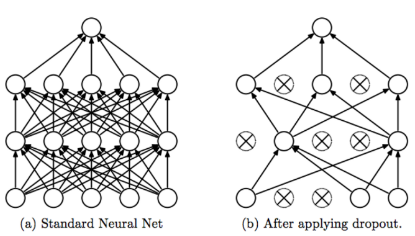

**tf.nn.dropout**(x, keep_prob, name=None)  
- keep_prob: 드롭하지 않고 유지할 노드의 비율을 나타내는 텐서  
  ex) 0.8로 설정하면 랜덤하게 20% 노드를 드롭

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
from tensorflow.keras.datasets.cifar10 import load_data

In [4]:
#다음 배치를 읽어오기 위한 함수
def next_batch(num, data, labels):
  idx = np.arrange(0, len(data))
  np.random.shuffle(idx)
  idx = idx[:num]
  data_shuffle = [data[i] for i in idx]
  labels_shuffle = [labels[i] for i in idx]
  return np.asarray(data_shuffle), np.asarray(labels_shuffle) 

**CNN 모델 구성**  
5개의 컨볼루션층 + 2개의 풀링층 + 2개의 완전 연결층  

In [5]:
def build_CNN_classifier(x):
  #3차원 형태로 reshape
  x_image = x

  #1번째 컨볼루션층: 64개의 특징으로 맵핑
  W_conv1 = tf.Variable(tf.truncated_normal(shape=[5,5,3,64], stddev=5e-2))
  b_conv1 = tf.Variable(tf.constant(0.1, shape=[64]))
  h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1,1,1,1], padding='SAME') + b_conv1)

  #1번째 풀링층
  h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')

  #2번째 컨볼루션층: 64개의 특징으로 맵핑
  W_conv2 = tf.Variable(tf.truncated_normal(shape=[5,5,64,64], stddev=5e-2))
  b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))
  h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W_conv2, strides=[1,1,1,1], padding='SAME') + b_conv2)

  #2번째 풀링층
  h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')

  #3번째 컨볼루션층
  W_conv3 = tf.Variable(tf.truncated_normal(shape=[3,3,64,128], stddev=5e-2))
  b_conv3 = tf.Variable(tf.constant(0.1, shape=[128]))
  h_conv3 = tf.nn.relu(tf.nn.conv2d(h_pool2, W_conv3, strides=[1,1,1,1], padding='SAME') + b_conv3)

  #4번째 컨볼루션층
  W_conv4 = tf.Variable(tf.truncated_normal(shape=[3,3,128,128], stddev=5e-2))
  b_conv4 = tf.Variable(tf.constant(0.1, shape=[128]))
  h_conv4 = tf.nn.relu(tf.nn.conv2d(h_pool, W_conv4, strides=[1,1,1,1], padding='SAME') + b_conv4)

  #5번째 컨볼루션층
  W_conv5 = tf.Variable(tf.truncated_normal(shape=[3,3,128,128], stddev=5e-2))
  b_conv5 = tf.Variable(tf.constant(0.1, shape=[128]))
  h_conv5 = tf.nn.relu(tf.nn.conv2d(h_pool, W_conv5, strides=[1,1,1,1], padding='SAME') + b_conv5)

  #1번째 완전 연결층: 384개의 특징으로 맵핑
  W_fc1 = tf.Variable(tf.truncated_normal(shape=[8*8*128, 384], stddev=5e-2))
  b_fc1 = tf.Variable(tf.constant(0.1, shape=[384]))
  #flatting
  h_conv5_flat = tf.reshape(h_conv5, [-1, 8*8*128])
  h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

  #Dropout
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  #출력층: 2번째 완전 연결층: 384개의 특징을 10개의 클래스로 맵핑
  W_output = tf.Variable(tf.truncated_normal(shape=[384, 10], stddev=5e-2))
  b_output = tf.Variable(tf.constant(0.1, shape=[10]))
  logits = tf.matmul(h_fc1_drop, W_output) + b_output
  y_pred = tf.nn.softmax(logits)

  return y_pred, logits

# 4. 대표적인 CNN 모델들  
---
## 1) Alexnet
Input + conv1 + pool1 + conv2 + pool2 + conv3 + conv4 + conv5 + pool3 + fc6 + fc7 + fc8

## 2) VGGNet
Alexnet와 다른점  
- 상대적으로 작은 크기의 필터만 사용
- 층의 깊이가 8에서 19까지 늘어남
- 1*1 컨볼루션 이후 ReLU 활성함수를 적용하므로 Non-Linearity 추가되어 모델의 표현력이 더욱 강해짐

## 3) GoogLeNet
- 기존의 컨볼루션층 대신에 구글에서 자체적으로 개발한 **인셉션 모듈** 구조로 대체

## 4) ResNet
- 깊이를 152층으로 획기적으로 늘린 모델
- Residual Block 모듈 사용


# 5. 모델과 파라미터를 저장하고 불러오기
---
1) 